# New Style HDMI input and Pixel Formatting

This notebook introduces the new features of PYNQ 2.0 for interacting with the video pipeline. The API has been completely
redesigned with high performance image processing applications in mind.

To start, download the base overlay and instantiate the HDMI input and output.

In [1]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *

base = BaseOverlay("add_dma.bit")
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

## Getting started

First we'll use the default pixel format which is 24 bit-per-pixel BGR formatted data for ease of use with OpenCV. 

In [2]:
import copy
hdmi_in.configure()
hdmi_out_mode = copy.copy(hdmi_in.mode)
print(hdmi_in.mode)
print(hdmi_out_mode)

# hdmi_out.configure(hdmi_out_mode)

VideoMode: width=3840 height=2160 bpp=24 fps=60
VideoMode: width=3840 height=2160 bpp=24 fps=60


In [3]:
hdmi_out_mode.width = 1920
hdmi_out_mode.height = 1080
# hdmi_out_mode.fps = 24
hdmi_out.configure(hdmi_out_mode)

In [4]:
hdmi_in.start()
hdmi_out.start()
hdmi_in.tie(hdmi_out)

The monitor should turn on and show a blank screen. To pass the image data through we can tie the output to the input. The tie will last until we send something else to be displayed.

While this provides for a fast way of passing video data through the pipeline there is no way to access or modify the frames. For that we a loop calling `readframe` and `writeframe`.

In [5]:
# start on dma passthrough 
from pynq import MMIO
import numpy as np
from pynq import allocate
print(hex(base.ip_dict['axi_dma_0']['phys_addr']))
axi_dma = MMIO(0x800e0000, 0x60)

0x800e0000


In [6]:
# Read the control logic of dma
print(hex(axi_dma.read(0)))     #MM2S control
print(hex(axi_dma.read(4)))     #MM2S status

print(hex(axi_dma.read(0x30)))  #S2MM control
print(hex(axi_dma.read(0x34)))  #S2MM status

0x10002
0x1
0x10002
0x1


In [10]:
# check the momory layout
f = hdmi_in.readframe()
_4k_byte = 3840 * 2160 * 3
output_buffer = allocate(shape=(_4k_byte,),dtype=np.uint8)

# set run/stop bit to 1
axi_dma.write(0, 1)
# set upper address
axi_dma.write(0x1c, 0)
# set lower address
axi_dma.write(0x18, f.device_address)
# set lenth in bytes (8*4)
axi_dma.write(0x28, _4k_byte)

# set run/stop bit to 1
axi_dma.write(0x30, 1)
# set upper address
axi_dma.write(0x4c, 0)
# set lower address
axi_dma.write(0x48, output_buffer.device_address)
# set lenth in bytes (4*4)
axi_dma.write(0x58, _4k_byte)

while hex(axi_dma.read(0x34)) != "0x1002":
          pass

print(f.shape)
print(output_buffer.shape)

print(len(f.tobytes()))
print(len(output_buffer.tobytes()))

print( f.tobytes() == output_buffer.tobytes())

all_True = True
for i in range(100, 110):
    print(i)
    for j in range(3840):
        for k in range(3):
            
            all_True = (all_True and f[i][j][k] == output_buffer[i * 3840 * 3 + j * 3 + k])
            
#             print(f[i][j][k] == output_buffer[i * 1920 * 3 + j * 3 + k])

print(all_True)

(2160, 3840, 3)
(24883200,)
24883200
24883200
True
100
101
102
103
104
105
106
107
108
109
True


In [20]:
import time

numframes = 6000
start = time.time()
_4k_byte = 3840 * 2160 * 3
output_buffer = allocate(shape=(_4k_byte,),dtype=np.uint8)
for _ in range(numframes):
    f = hdmi_in.readframe()
    
    # set run/stop bit to 1
    axi_dma.write(0, 1)
    # set upper address
    axi_dma.write(0x1c, 0)
    # set lower address
    axi_dma.write(0x18, f.device_address)
    # set lenth in bytes (8*4)
    axi_dma.write(0x28, _4k_byte)
    
    # set run/stop bit to 1
    axi_dma.write(0x30, 1)
    # set upper address
    axi_dma.write(0x4c, 0)
    # set lower address
    axi_dma.write(0x48, output_buffer.device_address)
    # set lenth in bytes (4*4)
    axi_dma.write(0x58, _4k_byte)
    
    while hex(axi_dma.read(0x34)) != "0x1002":
              pass
    
    hdmi_out.writeframe(output_buffer)
    
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

KeyboardInterrupt: 

Next we can start adding some OpenCV processing into the mix. For all of these examples we are going to use a Laplacian gradient filter. The first loop is going to perform the grayscale conversion in software.

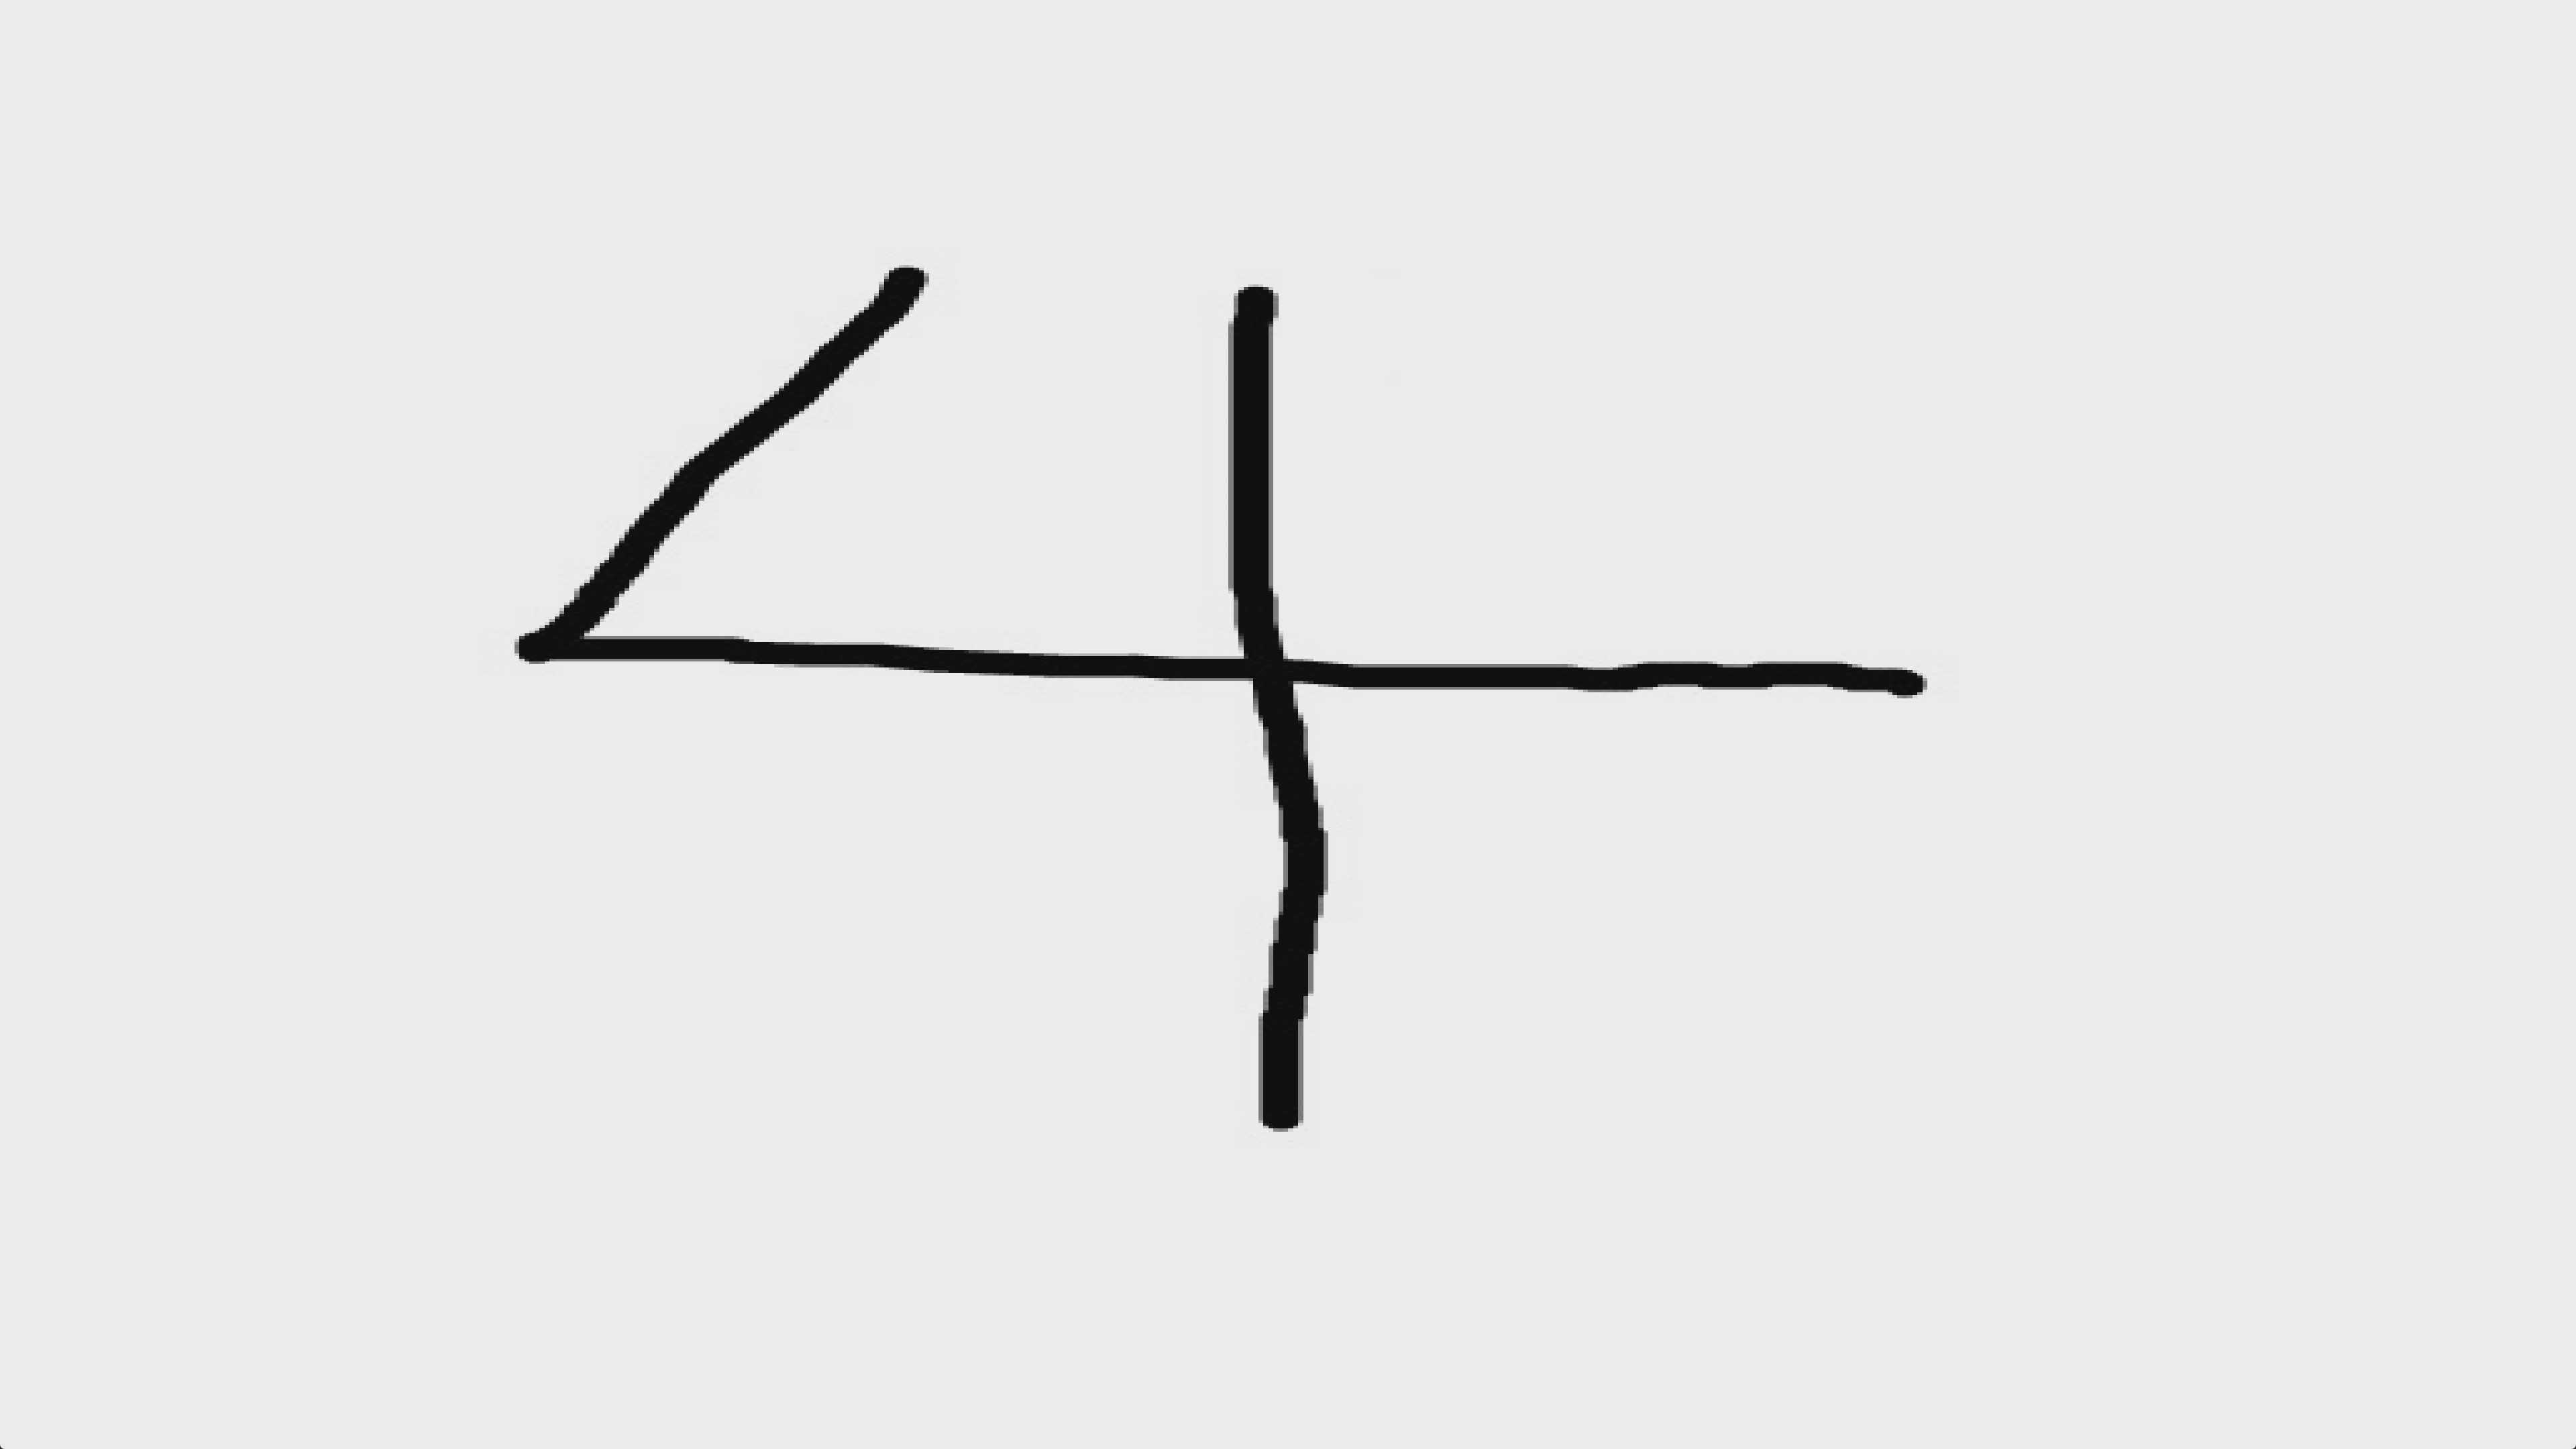

In [37]:
import PIL.Image
f = hdmi_in.readframe()
img = PIL.Image.fromarray(f)
img.save("4k.jpg")

img

## Cleaning up

Finally you must always stop the interfaces when you are done with them. Otherwise bad things can happen when the bitstream is reprogrammed. You can also use the HDMI interfaces in a context manager to ensure that the cleanup is always performed.

In [7]:
hdmi_out.close()
hdmi_in.close()